In [1]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import yellowbrick as yb
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

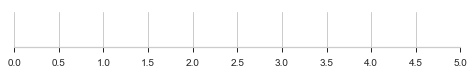

In [2]:
# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)


plt.figure(figsize=(8, 6))
n = 8

# Multiple Locator
ax_ = plt.subplot(n, 1, 2)
setup(ax_)
ax_.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
#ax_.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
#ax_.text(0.0, 0.1, "MultipleLocator(0.5)", fontsize=14, transform=ax_.transAxes)

In [3]:
# yellowbrick.cluster.silhouette
# Implements visualizers using the silhouette metric for cluster evaluation.
#
# Author:   Benjamin Bengfort <bbengfort@districtdatalabs.com>
# Created:  Mon Mar 27 10:09:24 2017 -0400
#
# Copyright (C) 2016 District Data Labs
# For license information, see LICENSE.txt
#
# ID: silhouette.py [57b563b] benjamin@bengfort.com $

"""
Implements visualizers that use the silhouette metric for cluster evaluation.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np

from yellowbrick.style import color_palette
from yellowbrick.cluster.base import ClusteringScoreVisualizer

from sklearn.metrics import silhouette_score, silhouette_samples


## Packages for export
__all__ = [
    "SilhouetteVisualizer"
]


##########################################################################
## Silhouette Method for K Selection
##########################################################################

class SilhouetteVisualizer(ClusteringScoreVisualizer):
    """
    The Silhouette Visualizer displays the silhouette coefficient for each
    sample on a per-cluster basis, visually evaluating the density and
    separation between clusters. The score is calculated by averaging the
    silhouette coefficient for each sample, computed as the difference
    between the average intra-cluster distance and the mean nearest-cluster
    distance for each sample, normalized by the maximum value. This produces a
    score between -1 and +1, where scores near +1 indicate high separation
    and scores near -1 indicate that the samples may have been assigned to
    the wrong cluster.

    In SilhouetteVisualizer plots, clusters with higher scores have wider
    silhouettes, but clusters that are less cohesive will fall short of the
    average score across all clusters, which is plotted as a vertical dotted
    red line.

    This is particularly useful for determining cluster imbalance, or for
    selecting a value for K by comparing multiple visualizers.

    Parameters
    ----------
    model : a Scikit-Learn clusterer
        Should be an instance of a centroidal clustering algorithm (``KMeans``
        or ``MiniBatchKMeans``).

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    silhouette_score_ : float
        Mean Silhouette Coefficient for all samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_score`.

    silhouette_samples_ : array, shape = [n_samples]
        Silhouette Coefficient for each samples. Computed via scikit-learn
        `sklearn.metrics.silhouette_samples`.

    n_samples_ : integer
        Number of total samples in the dataset (X.shape[0])

    n_clusters_ : integer
        Number of clusters (e.g. n_clusters or k value) passed to internal
        scikit-learn model.

    Examples
    --------

    >>> from yellowbrick.cluster import SilhouetteVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = SilhouetteVisualizer(KMeans(10))
    >>> model.fit(X)
    >>> model.show()
    """

    def __init__(self, model, ax=None, **kwargs):
        super(SilhouetteVisualizer, self).__init__(model, ax=ax, **kwargs)

        # Visual Properties
        # TODO: Fix the color handling
        self.colormap = kwargs.get('colormap', 'set1')
        self.color = kwargs.get('color', None)

    def fit(self, X, y=None, **kwargs):
        """
        Fits the model and generates the silhouette visualization.
        """
        # TODO: decide to use this method or the score method to draw.
        # NOTE: Probably this would be better in score, but the standard score
        # is a little different and I'm not sure how it's used.

        # Fit the wrapped estimator
        self.estimator.fit(X, y, **kwargs)

        # Get the properties of the dataset
        self.n_samples_ = X.shape[0]
        self.n_clusters_ = self.estimator.n_clusters

        # Compute the scores of the cluster
        labels = self.estimator.predict(X)
        self.silhouette_score_ = silhouette_score(X, labels)
        self.silhouette_samples_ = silhouette_samples(X, labels)

        # Draw the silhouette figure
        self.draw(labels)

        # Return the estimator
        return self

    def draw(self, labels):
        """
        Draw the silhouettes for each sample and the average score.

        Parameters
        ----------

        labels : array-like
            An array with the cluster label for each silhouette sample,
            usually computed with ``predict()``. Labels are not stored on the
            visualizer so that the figure can be redrawn with new data.
        """

        # Track the positions of the lines being drawn
        y_lower = 10 # The bottom of the silhouette

        # Get the colors from the various properties
        # TODO: Use resolve_colors instead of this
        colors = color_palette(self.colormap, self.n_clusters_)

        # For each cluster, plot the silhouette scores
        for idx in range(self.n_clusters_):

            # Collect silhouette scores for samples in the current cluster .
            values = self.silhouette_samples_[labels == idx]
            values.sort()

            # Compute the size of the cluster and find upper limit
            size = values.shape[0]
            y_upper = y_lower + size

            color = colors[idx]
            self.ax.fill_betweenx(
                np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.5
            )

            # Label the silhouette plots with their cluster numbers
            self.ax.text(-0.05, y_lower + 0.5 * size, str(idx))
            
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10

        # The vertical line for average silhouette score of all the values
        self.ax.axvline(
            x=self.silhouette_score_, color="red", linestyle="--"
        )

        return self.ax

    def finalize(self):
        """
        Prepare the figure for rendering by setting the title and adjusting
        the limits on the axes, adding labels and a legend.
        """

        # Set the title
        self.set_title((
            "Silhouette Plot of {} Clustering for {} Samples in {} Centers"
        ).format(
            self.name, self.n_samples_, self.n_clusters_
        ))

        # Set the X and Y limits
        # The silhouette coefficient can range from -1, 1;
        # but here we scale the plot according to our visualizations
        
        # l_xlim and u_xlim are lower and upper limits of the x-axis, 
        # set according to our calculated maximum and minimum silhouette score along with necessary padding
        l_xlim = max(-1, min(-0.1, round(min(self.silhouette_samples_)-0.1,1)))
        u_xlim = min(1, round(max(self.silhouette_samples_)+0.1,1))
        self.ax.set_xlim([l_xlim, u_xlim])

        # The (n_clusters_+1)*10 is for inserting blank space between
        # silhouette plots of individual clusters, to demarcate them clearly.
        self.ax.set_ylim([0, self.n_samples_ + (self.n_clusters_ + 1) * 10])

        # Set the x and y labels
        self.ax.set_xlabel("silhouette coefficient values")
        self.ax.set_ylabel("cluster label")

        # Set the ticks on the axis object.
        self.ax.set_yticks([])  # Clear the yaxis labels / ticks
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1)) # Set the ticks at multiples of 0.1


In [4]:
from sklearn.datasets import make_blobs

# Make blobs dataset
X, y = make_blobs(n_samples=1000, n_features=12, centers=8, shuffle=False, random_state=0)

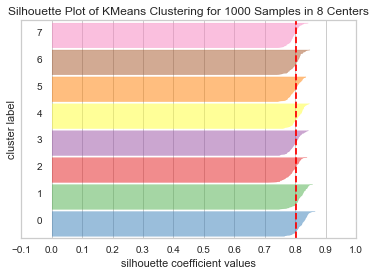

In [5]:
from sklearn.cluster import KMeans
# Instantiate the clustering model and visualizer
fig = plt.figure()
ax = fig.add_subplot()

model = KMeans(random_state=0)
visualizer = SilhouetteVisualizer(model, ax=ax)

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.show() # Draw/show/show the data

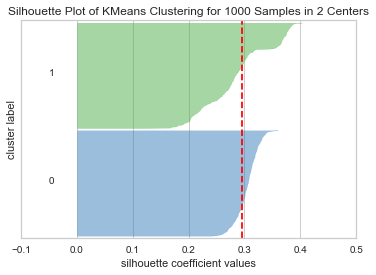

In [6]:
model = KMeans(n_clusters=2, random_state=0)
visualizer = SilhouetteVisualizer(model, ax=ax)

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.show() # Draw/show/show the data

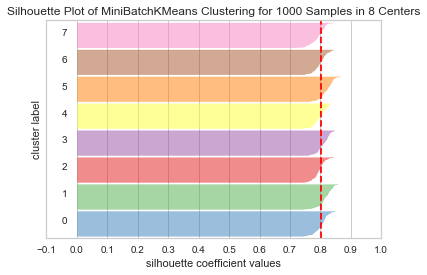

In [7]:
from sklearn.cluster import MiniBatchKMeans
# Instantiate the clustering model and visualizer
fig = plt.figure()
ax = fig.add_subplot()

model = MiniBatchKMeans(random_state=0)
visualizer = SilhouetteVisualizer(model, ax=ax)

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.show() # Draw/show/show the data

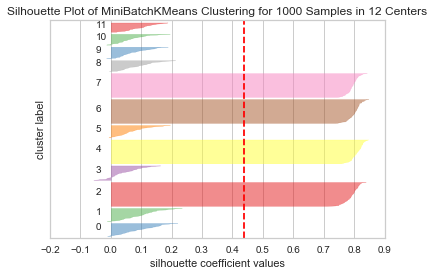

In [9]:
model = MiniBatchKMeans(n_clusters=12, random_state=0)
visualizer = SilhouetteVisualizer(model, ax=ax)

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.show() # Draw/show/show the data